## Import libraries

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Digit regconizer

## Traditional Machine learning

### Data import

In [3]:
train_master = pd.read_csv("../Assignment 1/digit-recognizer/train.csv")
test_master = pd.read_csv("../Assignment 1/digit-recognizer/test.csv")

train = train_master.copy().drop("label", axis=1)
label = train_master.label
test = test_master.copy()

In [5]:
print(train.shape)
print(label.shape)
print(test.shape)

(42000, 784)
(42000,)
(28000, 784)


### Splitting data

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(33600, 784)
(8400, 784)


### Train model

In [39]:
knn = KNeighborsClassifier(n_neighbors=1)
#knn.fit(X, y)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [40]:
y_pred = knn.predict(X_test)
print(y_pred)

[8 1 9 ... 3 0 9]


### Evaluation

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       816
           1       0.97      1.00      0.98       909
           2       0.98      0.95      0.97       846
           3       0.97      0.96      0.96       937
           4       0.98      0.97      0.97       839
           5       0.96      0.96      0.96       702
           6       0.98      0.99      0.98       785
           7       0.96      0.97      0.96       893
           8       0.98      0.94      0.96       835
           9       0.94      0.96      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



The digit is 7


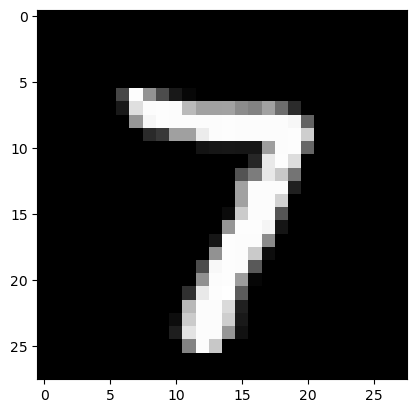

In [69]:
plt.imshow(X_test.iloc[1200].values.reshape(28, 28), cmap="gray")
print(f'The digit is {y_pred[1200]}')

## CNN

# Dog breed

## Traditional machine learning

## CNN